In [1]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

In [2]:
# Directories
fake_dir = r"D:\Revature\P1\28-8-24\training_fake"
real_dir = r"D:\Revature\P1\28-8-24\training_real"

In [3]:
# Function to load images from a directory and assign a label
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
        labels.append(label)
    return np.array(images), np.array(labels)

In [4]:
# Load fake and real images and their corresponding labels
fake_images, fake_labels = load_images_from_folder(fake_dir, label=0)
real_images, real_labels = load_images_from_folder(real_dir, label=1)

In [5]:
# Split fake images into training, validation, and test sets
X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(fake_images, fake_labels, test_size=0.2, random_state=42)
X_train_fake, X_val_fake, y_train_fake, y_val_fake = train_test_split(X_train_fake, y_train_fake, test_size=0.2, random_state=42)

In [6]:
# Split real images into training, validation, and test sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(real_images, real_labels, test_size=0.2, random_state=42)
X_train_real, X_val_real, y_train_real, y_val_real = train_test_split(X_train_real, y_train_real, test_size=0.2, random_state=42)


In [7]:
# Combine the training sets
X_train = np.concatenate((X_train_fake, X_train_real), axis=0)
y_train = np.concatenate((y_train_fake, y_train_real), axis=0)


In [8]:
# Combine the validation sets
X_val = np.concatenate((X_val_fake, X_val_real), axis=0)
y_val = np.concatenate((y_val_fake, y_val_real), axis=0)

In [9]:
# Combine the test sets
X_test = np.concatenate((X_test_fake, X_test_real), axis=0)
y_test = np.concatenate((y_test_fake, y_test_real), axis=0)

In [10]:
# Shuffle the combined training set
train_indices = np.arange(X_train.shape[0])
np.random.shuffle(train_indices)
X_train = X_train[train_indices]
y_train = y_train[train_indices]

In [11]:
# Shuffle the combined validation set
val_indices = np.arange(X_val.shape[0])
np.random.shuffle(val_indices)
X_val = X_val[val_indices]
y_val = y_val[val_indices]

In [12]:
# Shuffle the combined test set
test_indices = np.arange(X_test.shape[0])
np.random.shuffle(test_indices)
X_test = X_test[test_indices]
y_test = y_test[test_indices]

In [13]:
# Print dataset sizes
print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Testing set: {X_test.shape[0]} images")

Training set: 1305 images
Validation set: 327 images
Testing set: 409 images


In [14]:
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [15]:
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [16]:
# Load the VGG16 model with pre-trained weights, excluding the top (fully connected) layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [17]:
# Freeze the base layers so they are not trained during fine-tuning
vgg16_base.trainable = False


In [18]:
# Create a new model
model = models.Sequential()

In [19]:
# Add the VGG16 base model
model.add(vgg16_base)


In [20]:
# Add custom layers
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Regularization to prevent overfitting
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer for binary classification


In [21]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
# Fit the model
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    epochs=20
)

Epoch 1/20
40/40 [==============================] - 111s 3s/step - loss: 0.6547 - accuracy: 0.6182 - val_loss: 0.7104 - val_accuracy: 0.5566
Epoch 2/20
40/40 [==============================] - 78s 2s/step - loss: 0.6545 - accuracy: 0.6229 - val_loss: 0.6614 - val_accuracy: 0.5902
Epoch 3/20
40/40 [==============================] - 67s 2s/step - loss: 0.6525 - accuracy: 0.6174 - val_loss: 0.6375 - val_accuracy: 0.6391
Epoch 4/20
40/40 [==============================] - 66s 2s/step - loss: 0.6459 - accuracy: 0.6269 - val_loss: 0.6471 - val_accuracy: 0.5963
Epoch 5/20
40/40 [==============================] - 68s 2s/step - loss: 0.6508 - accuracy: 0.6133 - val_loss: 0.6509 - val_accuracy: 0.5963
Epoch 6/20
40/40 [==============================] - 63s 2s/step - loss: 0.6290 - accuracy: 0.6402 - val_loss: 0.6345 - val_accuracy: 0.6269
Epoch 7/20
40/40 [==============================] - 62s 2s/step - loss: 0.6382 - accuracy: 0.6347 - val_loss: 0.6315 - val_accuracy: 0.6239
Epoch 8/20
40/40 [=

In [24]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(val_datagen.flow(X_test, y_test, batch_size=32))
print(f"Test Accuracy: {test_acc:.4f}")


13/13 [==============================] - 15s 1s/step - loss: 0.6523 - accuracy: 0.6430
Test Accuracy: 0.6430


In [25]:

# Unfreeze the last few layers of VGG16
vgg16_base.trainable = True
for layer in vgg16_base.layers[:-4]:  # Unfreeze the last 4 layers
    layer.trainable = False

In [26]:
# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Continue training
history_fine = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    validation_data=val_datagen.flow(X_val, y_val, batch_size=32),
    epochs=10
) 

Epoch 1/10
40/40 [==============================] - 76s 2s/step - loss: 0.5943 - accuracy: 0.6724 - val_loss: 0.6617 - val_accuracy: 0.6177
Epoch 2/10
40/40 [==============================] - 76s 2s/step - loss: 0.5822 - accuracy: 0.6881 - val_loss: 0.6183 - val_accuracy: 0.6514
Epoch 3/10
40/40 [==============================] - 78s 2s/step - loss: 0.5703 - accuracy: 0.6952 - val_loss: 0.6258 - val_accuracy: 0.6483
Epoch 4/10
40/40 [==============================] - 80s 2s/step - loss: 0.5593 - accuracy: 0.7180 - val_loss: 0.6204 - val_accuracy: 0.6544
Epoch 5/10
40/40 [==============================] - 80s 2s/step - loss: 0.5579 - accuracy: 0.7227 - val_loss: 0.6569 - val_accuracy: 0.6147
Epoch 6/10
40/40 [==============================] - 80s 2s/step - loss: 0.5496 - accuracy: 0.7211 - val_loss: 0.6152 - val_accuracy: 0.6453
Epoch 7/10
40/40 [==============================] - 80s 2s/step - loss: 0.5304 - accuracy: 0.7196 - val_loss: 0.6160 - val_accuracy: 0.6300
Epoch 8/10
40/40 [==

In [29]:
# Evaluate again
test_loss, test_acc = model.evaluate(val_datagen.flow(X_test, y_test, batch_size=32))
print(f"Test Accuracy after fine-tuning: {test_acc:.4f}")

13/13 [==============================] - 15s 1s/step - loss: 0.6658 - accuracy: 0.6528
Test Accuracy after fine-tuning: 0.6528


In [44]:
# Save the model
model.save(r"D:\Revature\P1\28-8-24\model_final.h5") 

In [31]:
import matplotlib.pyplot as plt

In [39]:
# Plot training & validation accuracy values
plt.figure(figsize=(18, 40))

<Figure size 1800x4000 with 0 Axes>

<Figure size 1800x4000 with 0 Axes>

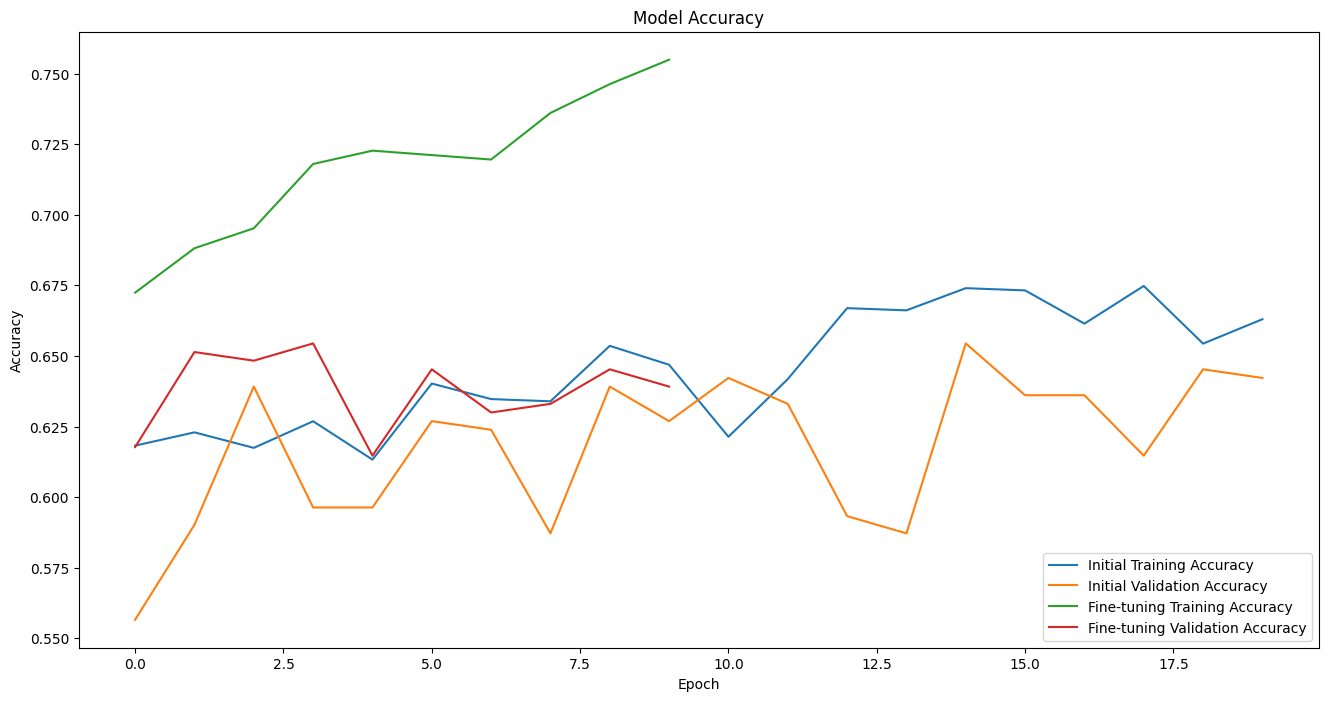

In [45]:
# Plot accuracy in a separate figure
plt.figure(figsize=(16, 8))
plt.plot(history.history['accuracy'], label='Initial Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Initial Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuning Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuning Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


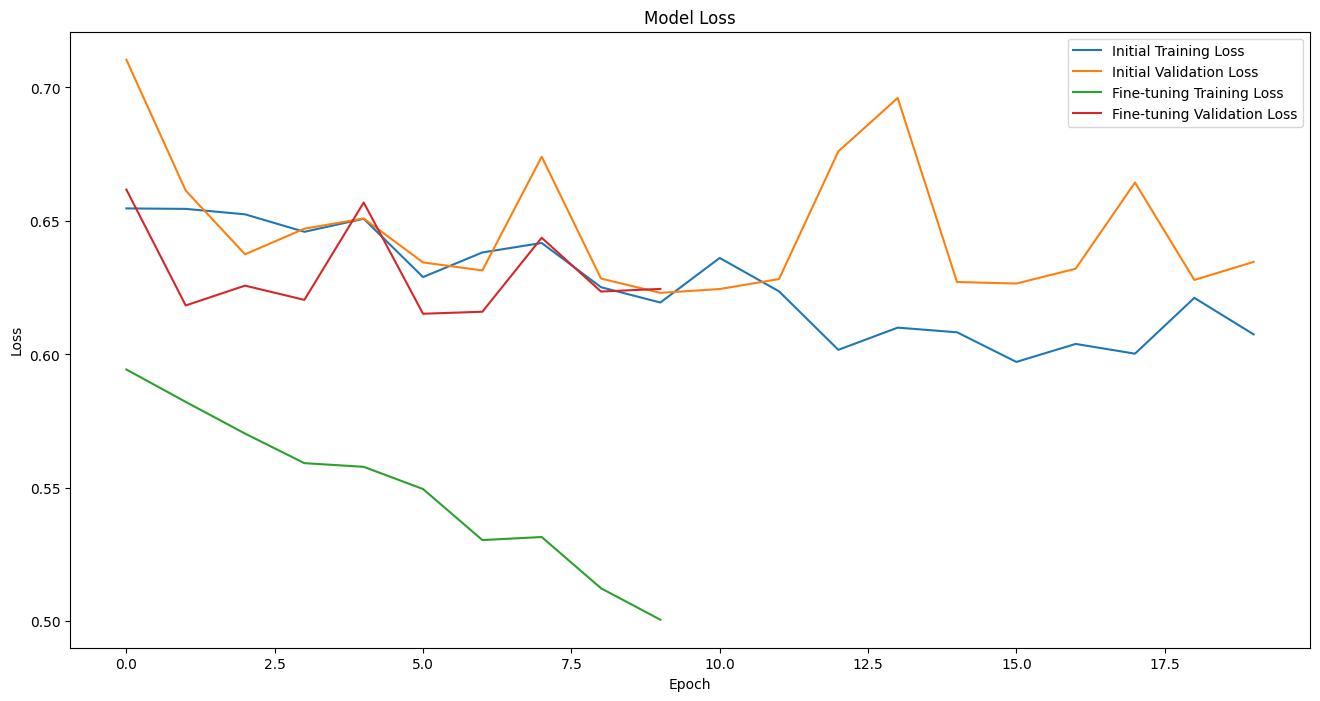

In [46]:
# Plot loss in a separate figure
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='Initial Training Loss')
plt.plot(history.history['val_loss'], label='Initial Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuning Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuning Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()